In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lzma

In [24]:
gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")

/local/scratch/klawren/slrmtmp.48905023/ipykernel_54562/2664361744.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")


In [15]:
import glob
import os

# Get all files ending with 'joint_gwas.txt' in the specified folder
files = glob.glob('/home/klawren/oak/gtex/output/coloc/single_tissue_gwas/**/*all_genes.colocboost.joint_gwas.txt', recursive=True)

# Load all files into a single DataFrame, keeping the filename as a column
dfs = []
for f in files:
    df = pd.read_csv(f, sep='\t')
    df['source_file'] = os.path.basename(f)
    dfs.append(df)
print('Found', len(dfs), 'joint gwas files')
all_joint_gwas_df = pd.concat(dfs, ignore_index=True)

all_joint_gwas_df['tissue_id'] = all_joint_gwas_df['source_file'].str.split('.').str[0]
all_joint_gwas_df['ld_block'] = all_joint_gwas_df['source_file'].str.split('.').str[1]
print('Found', all_joint_gwas_df['ld_block'].nunique(), 'unique ld blocks')
print('Found', all_joint_gwas_df['tissue_id'].nunique(), 'unique tissues')

Found 23 joint gwas files
Found 4 unique ld blocks
Found 10 unique tissues


In [18]:
# get to just lead variants
joint_gwas_lead_vars = (
    all_joint_gwas_df
    .sort_values('pip', ascending=False)
    .groupby(['phenotype_id', 'cs_id', 'tissue_id', 'ld_block'], as_index=False)
    .first()
)
print('Found', len(joint_gwas_lead_vars), 'loci')


Found 319 loci


In [29]:
# explode out to individual gene parts of phentoye to annotated with gene type
joint_gwas_lead_vars['individual_phenotype_id'] = joint_gwas_lead_vars['phenotype_id'].str.split(',')
joint_gwas_exploded = joint_gwas_lead_vars.explode('individual_phenotype_id')
joint_gwas_exploded['gene_id'] = np.where(joint_gwas_exploded['individual_phenotype_id'].str.contains('ENSG'), 
                                          joint_gwas_exploded['individual_phenotype_id'].str.split('.').str[1], 
                                          'GWAS')

# merge with gencode ids to get gene type
joint_gwas_exploded = pd.merge(joint_gwas_exploded, gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], left_on='gene_id', right_on='gene_id_stable', how='left')
joint_gwas_exploded['gene_type_grouped_highlight'].value_counts()

gene_type_grouped_highlight
protein_coding     19
existing_lncRNA    13
pseudogene          4
new_lncRNA          3
Name: count, dtype: int64

In [51]:
joint_gwas_exploded['individual_phenotype_id'].value_counts()

individual_phenotype_id
UKB_20127_Neuroticism_score                                               53
SSGAC_Education_Years_Pooled                                              40
UKB_50_Standing_height                                                    32
GIANT_HEIGHT                                                              25
UKB_20002_1225_self_reported_hyperthyroidism_or_thyrotoxicosis            21
                                                                          ..
UKB_20002_1452_self_reported_eczema_or_dermatitis                          1
Brain_Amygdala.ENSG00000082512.15                                          1
UKB_6150_1_Vascular_or_heart_problems_diagnosed_by_doctor_Heart_attack     1
UKB_6152_5_diagnosed_by_doctor_Blood_clot_in_the_leg_DVT                   1
tag.evrsmk.tbl                                                             1
Name: count, Length: 83, dtype: int64

In [53]:
# group back into sets

# First, add a column to indicate if the individual_phenotype_id is 'gwas'
joint_gwas_exploded['is_gwas'] = ~joint_gwas_exploded['individual_phenotype_id'].str.contains('ENSG')

joint_gwas_lead_var_annotated = joint_gwas_exploded.groupby(
    ['phenotype_id', 'cs_id', 'tissue_id', 'ld_block'], as_index=False
).agg({
    'gene_type_grouped_highlight': lambda x: [v for v in x if pd.notna(v)],
    'variant_id': 'first',
    'cos_npc': 'first',
    'is_gwas': 'sum',  # This will count the number of 'gwas' entries per group
})

# Rename 'is_gwas' to 'num_gwas' for clarity
joint_gwas_lead_var_annotated = joint_gwas_lead_var_annotated.rename(columns={'is_gwas': 'num_gwas'})

print(f'Found {len(joint_gwas_lead_var_annotated)} annotated loci')

Found 319 annotated loci


In [47]:
joint_gwas_lead_var_annotated['gene_type_grouped_highlight'].value_counts()

gene_type_grouped_highlight
[]                                                    290
[protein_coding]                                       11
[existing_lncRNA]                                       7
[protein_coding, existing_lncRNA]                       3
[pseudogene]                                            3
[existing_lncRNA, protein_coding, existing_lncRNA]      1
[protein_coding, new_lncRNA]                            1
[new_lncRNA, protein_coding, protein_coding]            1
[new_lncRNA]                                            1
[pseudogene, protein_coding, existing_lncRNA]           1
Name: count, dtype: int64

In [ ]:
new_lncrna_loci = joint_gwas_lead_var_annotated[
    joint_gwas_lead_var_annotated['gene_type_grouped_highlight'].apply(
        lambda x: isinstance(x, list) and x == ['new_lncRNA']
    )
]
print(f'Found {len(new_lncrna_loci)} new lncRNA specific loci')
new_lncrna_loci_with_gwas = new_lncrna_loci[new_lncrna_loci['num_gwas'] > 0]
print(f'Found {len(new_lncrna_loci_with_gwas)} new lncRNA specific loci with at least one GWAS signal')
new_lncrna_loci_with_gwas



Found 1 new lncRNA specific loci
Found 1 new lncRNA specific loci with at least one GWAS signal


,phenotype_id,cs_id,tissue_id,ld_block,gene_type_grouped_highlight,variant_id,cos_npc,num_gwas
21,"Artery_Coronary.ENSG00000300476.1,SSGAC_Educat...",cos2:y12_y85,Artery_Coronary,chr1:210906848-211356227,[new_lncRNA],chr1:211116563:C:A:b38,0.5963,1


## pick an example loci and disect
* chr1:211116563:C:A:b38 is new lncRNA only, but the new lncrNA p value is 1e-3 (very very sub threshold)

In [187]:
example_loci = new_lncrna_loci.iloc[0]
#example_loci = joint_gwas_lead_var_annotated.iloc[4]
print(example_loci)

phenotype_id                   Artery_Coronary.ENSG00000300476.1,SSGAC_Educat...
cs_id                                                               cos2:y12_y85
tissue_id                                                        Artery_Coronary
ld_block                                                chr1:210906848-211356227
gene_type_grouped_highlight                                         [new_lncRNA]
variant_id                                                chr1:211116563:C:A:b38
cos_npc                                                                   0.5963
num_gwas                                                                       1
Name: 21, dtype: object


In [188]:
# Get the subset of all_joint_gwas_df that matches the first new lncRNA locus by phenotype_id, cs_id, tissue_id, and ld_block
example_gwas_ids = [individual_phenotype_id for individual_phenotype_id in example_loci['phenotype_id'].split(',') if 'ENSG' not in individual_phenotype_id]
example_gene_ids = ['.'.join(individual_phenotype_id.split('.')[1:]) for individual_phenotype_id in example_loci['phenotype_id'].split(',') if 'ENSG' in individual_phenotype_id]
example_loci_coloc = all_joint_gwas_df[
    (all_joint_gwas_df['phenotype_id'] == example_loci['phenotype_id']) &
    (all_joint_gwas_df['cs_id'] == example_loci['cs_id']) &
    (all_joint_gwas_df['tissue_id'] == example_loci['tissue_id']) &
    (all_joint_gwas_df['ld_block'] == example_loci['ld_block'])
]
example_loci_coloc

,phenotype_id,variant_id,pip,neg_log10_p_value,cs_id,cs_type,cos_npc,source_file,tissue_id,ld_block
3414,"Artery_Coronary.ENSG00000300476.1,SSGAC_Educat...",chr1:211116563:C:A:b38,0.559379,"2.53062, 8.35458",cos2:y12_y85,trait_shared,0.5963,Artery_Coronary.chr1:210906848-211356227.all_g...,Artery_Coronary,chr1:210906848-211356227
3415,"Artery_Coronary.ENSG00000300476.1,SSGAC_Educat...",chr1:211124505:G:A:b38,0.346594,"2.43733, 8.24458",cos2:y12_y85,trait_shared,0.5963,Artery_Coronary.chr1:210906848-211356227.all_g...,Artery_Coronary,chr1:210906848-211356227
3416,"Artery_Coronary.ENSG00000300476.1,SSGAC_Educat...",chr1:211129564:A:T:b38,0.093876,"2.16259, 8.22315",cos2:y12_y85,trait_shared,0.5963,Artery_Coronary.chr1:210906848-211356227.all_g...,Artery_Coronary,chr1:210906848-211356227


#### data loading

In [189]:
# load in the nominal associations for that gene and gwas
gene_nominal_dir = '/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL_all_associations'
ld_dir = '/home/klawren/oak/gtex/data/pecotmr_references/ld_blocks_gtex_eur'
gwas_nominal_dir = '/home/klawren/oak/gtex/data/barbeira_gtex_imputed/imputed_gwas_hg38_1.1'


gene_nominal_associations = pd.read_parquet(f'{gene_nominal_dir}/{example_loci["tissue_id"]}.v11.allpairs.{example_loci["variant_id"].split(":")[0]}.parquet')
print('Loaded gene nominal associations')

ld_block_id = example_loci['ld_block'].replace(":", "_").replace("-", "_")
ld_block_snp_list = pd.read_table(f"{ld_dir}/LD_{ld_block_id}.bim", header=None, names=['chr', 'variant_id', 'cm', 'pos', 'a1', 'a2'])
with lzma.open(f"{ld_dir}/LD_{ld_block_id}.ld.gz", 'rt') as f:
    ld_block_df = pd.read_csv(f, delim_whitespace=True, header=None)
    ld_block_df.index = ld_block_snp_list['variant_id']
    ld_block_df.columns = ld_block_snp_list['variant_id']
print('Loaded LD block')

gwas_nominal_associations = []
for gwas_id in example_gwas_ids:
    gwas_nominal_association = pd.read_csv(f'{gwas_nominal_dir}/imputed_{gwas_id}.txt.gz', sep='\t')
    gwas_nominal_association['gwas_id'] = gwas_id
    gwas_nominal_associations.append(gwas_nominal_association)
    print(f'Loaded GWAS nominal associations for {gwas_id}')
gwas_nominal_associations = pd.concat(gwas_nominal_associations)
print('Loaded GWAS nominal associations')

Loaded gene nominal associations


/local/scratch/klawren/slrmtmp.48905023/ipykernel_54562/2183381050.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ld_block_df = pd.read_csv(f, delim_whitespace=True, header=None)


Loaded LD block
Loaded GWAS nominal associations for SSGAC_Education_Years_Pooled
Loaded GWAS nominal associations


In [190]:
# get variants from the ld block
ld_block_start = int(example_loci['ld_block'].split(':')[1].split('-')[0])
ld_block_end = int(example_loci['ld_block'].split(':')[1].split('-')[1])

# Filter genes
gene_nominal_associations_block = gene_nominal_associations[gene_nominal_associations['gene_id'].isin(example_gene_ids)]
gene_nominal_associations_block['pos'] = gene_nominal_associations_block['variant_id'].str.split('_').str[1].astype(int)
gene_nominal_associations_block = gene_nominal_associations_block[
    (gene_nominal_associations_block['pos'] >= ld_block_start) &
    (gene_nominal_associations_block['pos'] <= ld_block_end)
]

# Filter gwas
gwas_nominal_associations_block = gwas_nominal_associations[
    (gwas_nominal_associations['panel_variant_id'].isin(gene_nominal_associations_block['variant_id'].unique()))]

/local/scratch/klawren/slrmtmp.48905023/ipykernel_54562/1964161694.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_nominal_associations_block['pos'] = gene_nominal_associations_block['variant_id'].str.split('_').str[1].astype(int)


#### locus zoom

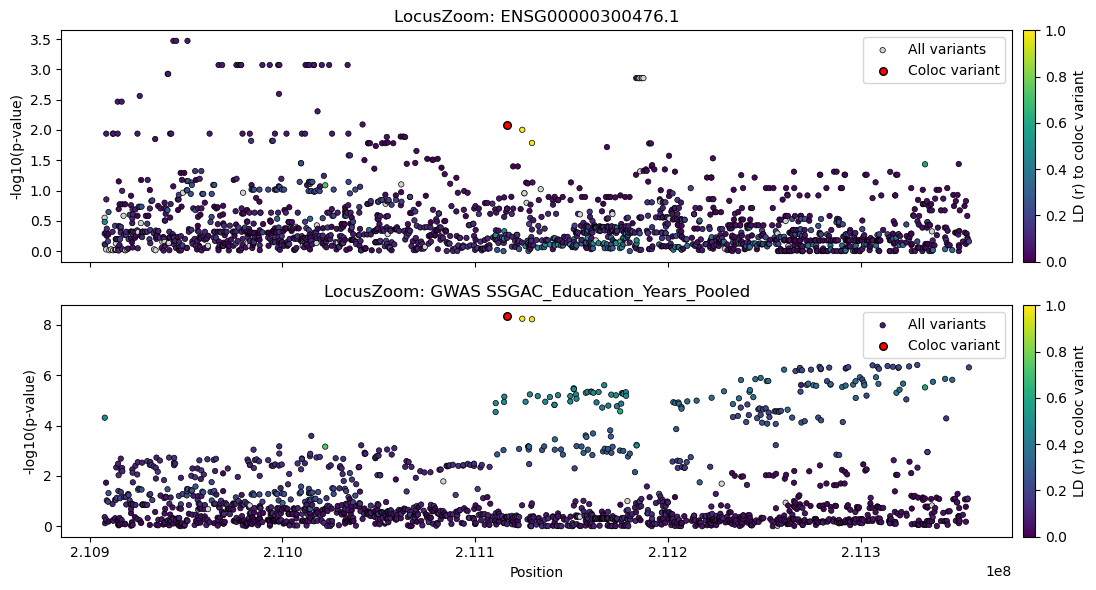

In [ ]:
# Make a locus zoom plot with multiple axes, all sharing the x axis

# Use the variant_id from example_loci, replacing ":" with "_"
coloc_variant_id = example_loci['variant_id'].replace(":", "_")
variant_highlight_set = set([coloc_variant_id])

# Get LD (r) of each variant to the coloc variant
if coloc_variant_id in ld_block_df.columns:
    ld_to_coloc = ld_block_df[coloc_variant_id].abs()
else:
    # If coloc variant not in LD matrix, fill with NaN
    ld_to_coloc = pd.Series(np.nan, index=ld_block_df.index)

n_gene = len(example_gene_ids)
n_gwas = len(example_gwas_ids)
n_axes = n_gene + n_gwas

fig, axs = plt.subplots(n_axes, 1, sharex=True, figsize=(12, 3 * n_axes))

# If only one axis, put it into a list for uniform iteration
if n_axes == 1:
    axs = [axs]

ax_idx = 0

# Plot per gene
for gene_id in example_gene_ids:
    ax = axs[ax_idx]
    gene_nominal_associations_block_gene = gene_nominal_associations_block[
        gene_nominal_associations_block['gene_id'] == gene_id
    ].copy()
    # Get LD for each variant in this gene
    gene_nominal_associations_block_gene['ld_to_coloc'] = gene_nominal_associations_block_gene['variant_id'].map(ld_to_coloc)
    # Color by LD (r), use a colormap, e.g., 'viridis', with grey for NaN
    colors = gene_nominal_associations_block_gene['ld_to_coloc']
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(0, 1)
    default_color = 'lightgrey'
    color_vals = [
        cmap(norm(ld)) if not np.isnan(ld) else default_color
        for ld in colors
    ]
    sc = ax.scatter(
        gene_nominal_associations_block_gene['pos'],
        -np.log10(gene_nominal_associations_block_gene['pval_nominal']),
        c=color_vals, alpha=1, label='All variants', s=15, edgecolor='k', lw=0.5
    )
    # Highlight coloc variant with a black edge
    highlights = gene_nominal_associations_block_gene[
        gene_nominal_associations_block_gene['variant_id'] == coloc_variant_id
    ]
    if not highlights.empty:
        ax.scatter(
            highlights['pos'],
            -np.log10(highlights['pval_nominal']),
            color='red', alpha=1, label='Coloc variant', s=30, edgecolor='black', linewidth=1
        )
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"LocusZoom: {gene_id}")
    # Add colorbar for LD
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label('LD (r) to coloc variant')
    ax.legend()
    ax_idx += 1

# Plot per GWAS
for gwas_id in example_gwas_ids:
    ax = axs[ax_idx]
    gwas_block = gwas_nominal_associations_block[
        gwas_nominal_associations_block['gwas_id'] == gwas_id
    ].copy()
    if "panel_variant_id" in gwas_block.columns:
        variant_col = "panel_variant_id"
    else:
        variant_col = "variant_id"
    # Extract variant positions
    gwas_block['pos'] = gwas_block[variant_col].str.split('_').str[1].astype(int)
    # Get LD for each variant in this GWAS
    gwas_block['ld_to_coloc'] = gwas_block[variant_col].map(ld_to_coloc)
    colors = gwas_block['ld_to_coloc']
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(0, 1)
    default_color = 'lightgrey'
    color_vals = [
        cmap(norm(ld)) if not np.isnan(ld) else default_color
        for ld in colors
    ]
    sc = ax.scatter(
        gwas_block['pos'],
        -np.log10(gwas_block['pvalue']),
        c=color_vals, alpha=1, label='All variants', s=15, edgecolor='k', lw=0.5
    )
    # Highlight coloc variant with a black edge
    highlights = gwas_block[gwas_block[variant_col] == coloc_variant_id]
    if not highlights.empty:
        ax.scatter(
            highlights['pos'],
            -np.log10(highlights['pvalue']),
            color='red', alpha=1, label='Coloc variant', s=30, edgecolor='black', linewidth=1
        )
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"LocusZoom: GWAS {gwas_id}")
    # Add colorbar for LD
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label('LD (r) to coloc variant')
    ax.legend()
    ax_idx += 1
_gwas        --strong_only ${strong_only}

# Set common x-label on bottom axis
axs[-1].set_xlabel("Position")
plt.tight_layout()
plt.show()


### locus compare

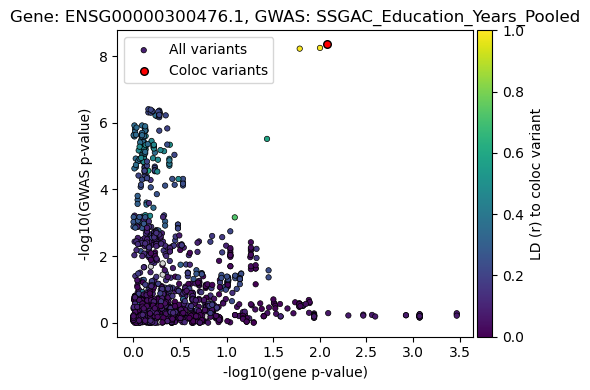

In [192]:
n_rows = len(example_gene_ids)
n_cols = len(example_gwas_ids)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 1)
default_color = 'lightgrey'

for i, gene_id in enumerate(example_gene_ids):
    gene_block = gene_nominal_associations_block[
        gene_nominal_associations_block['gene_id'] == gene_id
    ].copy()
    gene_block = gene_block.set_index('variant_id')

    for j, gwas_id in enumerate(example_gwas_ids):
        ax = axs[i, j]
        gwas_block = gwas_nominal_associations_block[
            gwas_nominal_associations_block['gwas_id'] == gwas_id
        ].copy()

        # Use panel_variant_id if present
        if "panel_variant_id" in gwas_block.columns:
            gwas_block['panel_variant_id'] = gwas_block['panel_variant_id'].astype(str)
            gwas_block = gwas_block.set_index('panel_variant_id')
            variant_ids = set(gene_block.index).intersection(set(gwas_block.index))
            variant_ids = list(variant_ids)  # Convert set to list for indexing
            gene_vals = gene_block.loc[variant_ids, 'pval_nominal']
            gwas_vals = gwas_block.loc[variant_ids, 'pvalue']
            plot_index = variant_ids
        else:
            gwas_block = gwas_block.set_index('variant_id')
            variant_ids = set(gene_block.index).intersection(set(gwas_block.index))
            variant_ids = list(variant_ids)  # Convert set to list for indexing
            gene_vals = gene_block.loc[variant_ids, 'pval_nominal']
            gwas_vals = gwas_block.loc[variant_ids, 'pvalue']
            plot_index = variant_ids

        # Get LD values for coloring
        ld_vals = [ld_to_coloc.get(vid, np.nan) for vid in plot_index]
        color_vals = [
            cmap(norm(ld)) if not np.isnan(ld) else default_color
            for ld in ld_vals
        ]

        # Plot all variant points colored by LD
        ax.scatter(
            -np.log10(gene_vals),
            -np.log10(gwas_vals),
            c=color_vals, alpha=1, label='All variants', s=15, edgecolor='k', lw=0.5
        )

        # Highlight coloc variants
        highlight_vars = [i for i in plot_index if i in variant_highlight_set]
        if len(highlight_vars) > 0:
            ax.scatter(
                -np.log10(gene_block.loc[highlight_vars, 'pval_nominal']),
                -np.log10(gwas_block.loc[highlight_vars, 'pvalue']),
                color='red', alpha=1, label='Coloc variants', s=30, edgecolor='black', linewidth=1
            )

        if i == n_rows - 1:
            ax.set_xlabel("-log10(gene p-value)")
        if j == 0:
            ax.set_ylabel("-log10(GWAS p-value)")

        ax.set_title(f"Gene: {gene_id}, GWAS: {gwas_id}")
        ax.legend()

        # Add colorbar for LD
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, pad=0.01)
        cbar.set_label('LD (r) to coloc variant')

plt.tight_layout()
plt.show()
